In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models import NHiTSModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
import json


torch.set_float32_matmul_precision('medium')


In [2]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [3]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [4]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

tscv = TimeSeriesSplit(n_splits=7)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)
    

    model = NHiTSModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=45,
        output_chunk_length=1,
        activation="GELU",
        num_layers=1,
        num_blocks=4,
        num_stacks=3,
        layer_widths=243,
        n_epochs=100,
        batch_size=104,
        dropout=0.1300946376042601,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.HuberLoss(),
        optimizer_cls=torch.optim.AdamW,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode": "min", "factor": 0.3, "patience": 5, "min_lr": 1e-7},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        optimizer_kwargs={"lr": 0.00011494227662736073, "weight_decay": 8.444384638688174e-05}
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )
    
    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    forecasts = model.historical_forecasts(
        val_scaled,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")



Fold 1

Treinando o modelo...
Train set: 1043 samples
Validation set: 1038 samples


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.110
Metric val_loss improved by 0.079 >= min_delta = 0.001. New best score: 0.031
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.029
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.027
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.024
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.022
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.021
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.020
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.020. Signaling Trainer to st

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    15.045593    3.878865    3.108440  0.700084   
Precipitation_accumulated       0.209145    0.457324    0.345090  0.671986   
Humidity                      163.698424   12.794468   10.393300  0.484279   
Wind_Speed_kmh                  2.409651    1.552305    1.318364 -4.641617   
Soil_Moisture              180194.405325  424.493116  294.267900  0.713038   
Soil_Temperature               34.252540    5.852567    4.310247  0.528949   
Wind_Dir_Sin                    0.303748    0.551134    0.440824  0.057264   
Wind_Dir_Cos                    0.327105    0.571931    0.439229  0.125869   

                                SMAPE  
Temperature                 18.966669  
Precipitation_accumulated   10.465335  
Humidity                    18.027044  
Wind_Speed_kmh              81.726412  
Soil_Mo

Metric val_loss improved. New best score: 29.086
Metric val_loss improved by 1.657 >= min_delta = 0.001. New best score: 27.430
Metric val_loss improved by 1.943 >= min_delta = 0.001. New best score: 25.486
Metric val_loss improved by 0.703 >= min_delta = 0.001. New best score: 24.784
Metric val_loss improved by 1.478 >= min_delta = 0.001. New best score: 23.305
Metric val_loss improved by 0.545 >= min_delta = 0.001. New best score: 22.760
Metric val_loss improved by 0.706 >= min_delta = 0.001. New best score: 22.054
Metric val_loss improved by 0.183 >= min_delta = 0.001. New best score: 21.871
Metric val_loss improved by 0.535 >= min_delta = 0.001. New best score: 21.336
Metric val_loss improved by 0.366 >= min_delta = 0.001. New best score: 20.971
Metric val_loss improved by 0.072 >= min_delta = 0.001. New best score: 20.898
Metric val_loss improved by 1.057 >= min_delta = 0.001. New best score: 19.842
Metric val_loss improved by 0.357 >= min_delta = 0.001. New best score: 19.485
Met

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE          RMSE           MAE  \
Temperature                2.256095e+04    150.203038    127.780818   
Precipitation_accumulated  1.938925e+04    139.245276    118.719549   
Humidity                   4.516219e+05    672.028208    571.715252   
Wind_Speed_kmh             2.045291e+02     14.301366      8.437353   
Soil_Moisture              2.950394e+09  54317.524940  46503.284613   
Soil_Temperature           2.651679e+05    514.944534    437.088023   
Wind_Dir_Sin               1.166124e+04    107.987208     92.124885   
Wind_Dir_Cos               2.641557e+01      5.139608      3.165360   

                                     R2       SMAPE  
Temperature                 -650.709574  156.114455  
Precipitation_accumulated      0.496279   34.930606  
Humidity                   -3575.192274  123.309369  
Wind_Speed_kmh              -644.113651  155.972340  


Metric val_loss improved. New best score: 0.023
Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.012
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.008
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.005
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.005. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                   27.340655    5.228829    4.640396 -4.123219e+00   
Precipitation_accumulated   9071.231284   95.243012   87.373201 -8.152962e+07   
Humidity                      61.135338    7.818909    6.533230 -2.532060e+00   
Wind_Speed_kmh                 0.053801    0.231950    0.179534          -inf   
Soil_Moisture              76424.209328  276.449289  213.396366 -5.568425e+01   
Soil_Temperature              28.465996    5.335353    4.552255 -3.686987e+00   
Wind_Dir_Sin                   0.018190    0.134872    0.113843          -inf   
Wind_Dir_Cos                   0.019759    0.140566    0.116580          -inf   

                                SMAPE  
Temperature                 28.569680  
Precipitation_accumulated   17.156016  
Humidity                     7.160347  
Wind_Speed_kmh      

Metric val_loss improved. New best score: 0.006
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.004
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.002
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.002. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encount

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                    3.747866    1.935941    1.616561 -5.916529e+00   
Precipitation_accumulated    413.866601   20.343712   13.818231 -1.246720e+04   
Humidity                      31.468145    5.609647    4.507957 -2.174248e+00   
Wind_Speed_kmh                 0.107454    0.327801    0.260334          -inf   
Soil_Moisture              28030.301850  167.422525  114.146532  1.400326e-01   
Soil_Temperature              19.813909    4.451282    3.691278 -9.300110e+01   
Wind_Dir_Sin                   0.010761    0.103733    0.084860          -inf   
Wind_Dir_Cos                   0.014079    0.118655    0.088910          -inf   

                                SMAPE  
Temperature                 15.538860  
Precipitation_accumulated    2.989527  
Humidity                     4.889334  
Wind_Speed_kmh      

Metric val_loss improved. New best score: 0.010
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.006
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.004
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.003
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.003. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Specified future encoders in `add_encoders` at model creation but model does 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    4.385696    2.094205    1.339422    -0.861231   
Precipitation_accumulated   1547.751731   39.341476   34.172780 -5376.559144   
Humidity                      40.257483    6.344879    5.371724     0.117827   
Wind_Speed_kmh                 0.213464    0.462021    0.361318  -100.023457   
Soil_Moisture              41462.631631  203.623750  183.263463    -4.073533   
Soil_Temperature               1.302708    1.141362    0.883039     0.190432   
Wind_Dir_Sin                   0.028996    0.170283    0.087696     0.505883   
Wind_Dir_Cos                   0.051294    0.226482    0.173395     0.428373   

                                SMAPE  
Temperature                 30.607906  
Precipitation_accumulated    7.832107  
Humidity                     6.361757  
Wind_Speed_kmh             19

Metric val_loss improved. New best score: 0.037
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.029
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.023
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.021
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.020
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.017
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.016
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.015
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.015. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connecto

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE          R2  \
Temperature                     3.584471    1.893270    1.482713    0.622655   
Precipitation_accumulated     596.828859   24.430081   19.682561 -518.592493   
Humidity                       30.013559    5.478463    4.159638    0.735011   
Wind_Speed_kmh                  1.186832    1.089418    0.818162    0.237053   
Soil_Moisture              712685.129555  844.206805  740.058482    0.415865   
Soil_Temperature                5.183682    2.276770    1.690986   -0.031044   
Wind_Dir_Sin                    0.363139    0.602610    0.451852    0.249733   
Wind_Dir_Cos                    0.288900    0.537494    0.421647    0.403018   

                                SMAPE  
Temperature                 40.802356  
Precipitation_accumulated    4.398860  
Humidity                     4.610270  
Wind_Speed_kmh              9

Metric val_loss improved. New best score: 0.022
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.019
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.017
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.016
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.014
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.014. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    6.592230    2.567534    2.082758     0.754667   
Precipitation_accumulated    449.740005   21.207074   17.740768 -1676.739766   
Humidity                      48.532974    6.966561    5.566279     0.674326   
Wind_Speed_kmh                 0.882982    0.939671    0.746047     0.263530   
Soil_Moisture              23814.691756  154.320095  123.887323    -2.992421   
Soil_Temperature               4.570920    2.137971    1.749642     0.588339   
Wind_Dir_Sin                   0.470264    0.685758    0.586502     0.127544   
Wind_Dir_Cos                   0.324462    0.569615    0.478681     0.029524   

                                SMAPE  
Temperature                 21.462556  
Precipitation_accumulated    3.912995  
Humidity                     6.808685  
Wind_Speed_kmh              6

In [5]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

NHiTSModel(output_chunk_shift=0, num_stacks=3, num_blocks=4, num_layers=1, layer_widths=243, pooling_kernel_sizes=None, n_freq_downsample=None, dropout=0.1300946376042601, activation=GELU, MaxPool1d=True, model_name=model_1, input_chunk_length=45, output_chunk_length=1, n_epochs=100, batch_size=104, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7feaebfcc950>]}, loss_fn=HuberLoss(), optimizer_cls=<class 'torch.optim.adamw.AdamW'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.3, 'patience': 5, 'min_lr': 1e-07}, save_checkpoints=True, show_warnings=True, force_reset=True, optimizer_kwargs={'lr': 0.0001149422766273

In [6]:
s = best_scaler.inverse_transform(best_val_scaled)
forecasts_t = best_scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


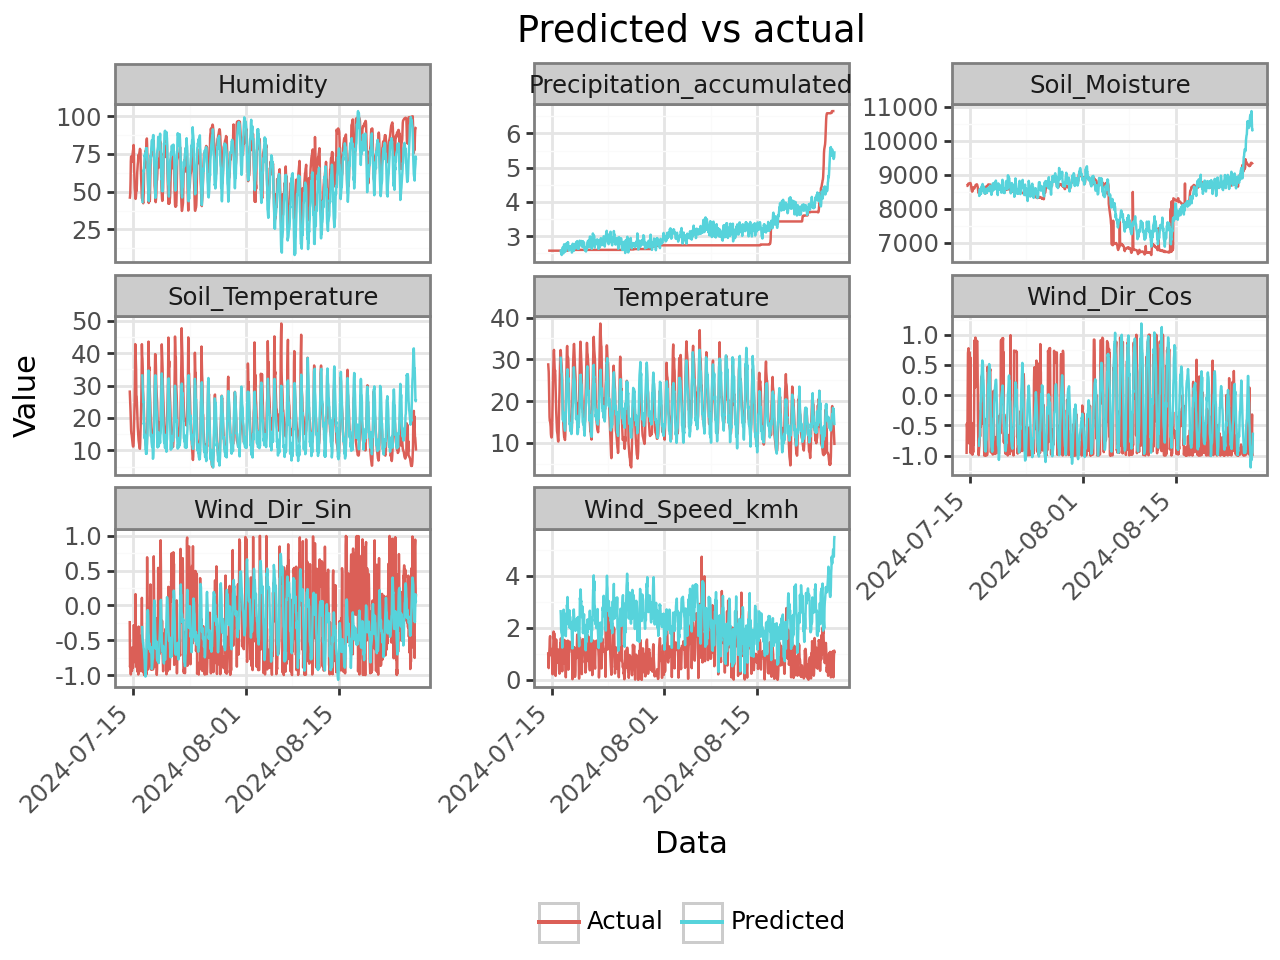

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual.png


In [7]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Actual'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Predicted'

df_combined = pd.concat([s_melted, forecasts_t_melted])

df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot.show()
plot.save('predict_actual.png', width=12, height=10, dpi=300)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

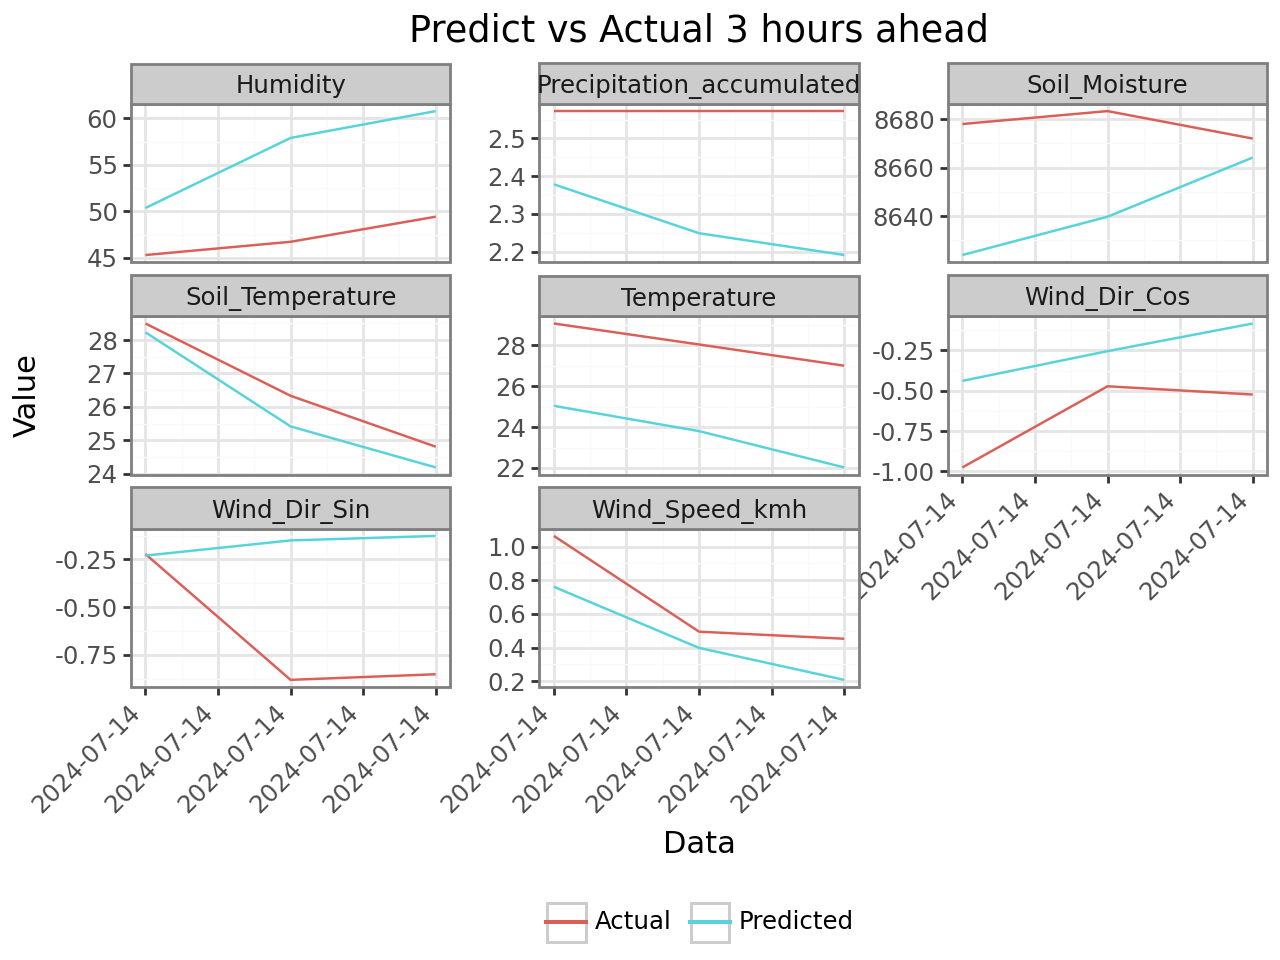

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/NHiTS/predict_3.png
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(19.64628689721943), 'RMSE': np.float64(4.4324132137267425), 'MAE': np.float64(4.413705599112287), 'R2': np.float64(-26.67663318643819), 'SMAPE': np.float64(17.177430402947323)}, 'Precipitation_accumulated': {'MSE': np.float64(0.09607888295793875), 'RMSE': np.float64(0.3099659383834597), 'MAE': np.float64(0.29990214379316776), 'R2': np.float64(-inf), 'SMAPE': np.float64(12.434284713594243)}, 'Humidity': {'MSE': np.float64(92.93864612139612), 'RMSE': np.float64(9.640469185750044), 'MAE': np.float64(9.186149077424835), 'R2': np.float64(-30.885049674151645), 'SMAPE': np.float64(17.497735256295297)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.053587768288777066), 'RMSE': np.float64(0.2314903200757584), 'MAE': np.float64(0.2146030350006312), 'R2': np.float64(0.31134131563285616), 'SMAPE': np.float64(42.989842195949564)}, 'Soil_Moisture': {'MSE': np.float64(1629.2534214767902), 'RMSE': np.float64(40.36401146413461), 'MAE': np.float64(35.178474347621886), 'R2': n

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

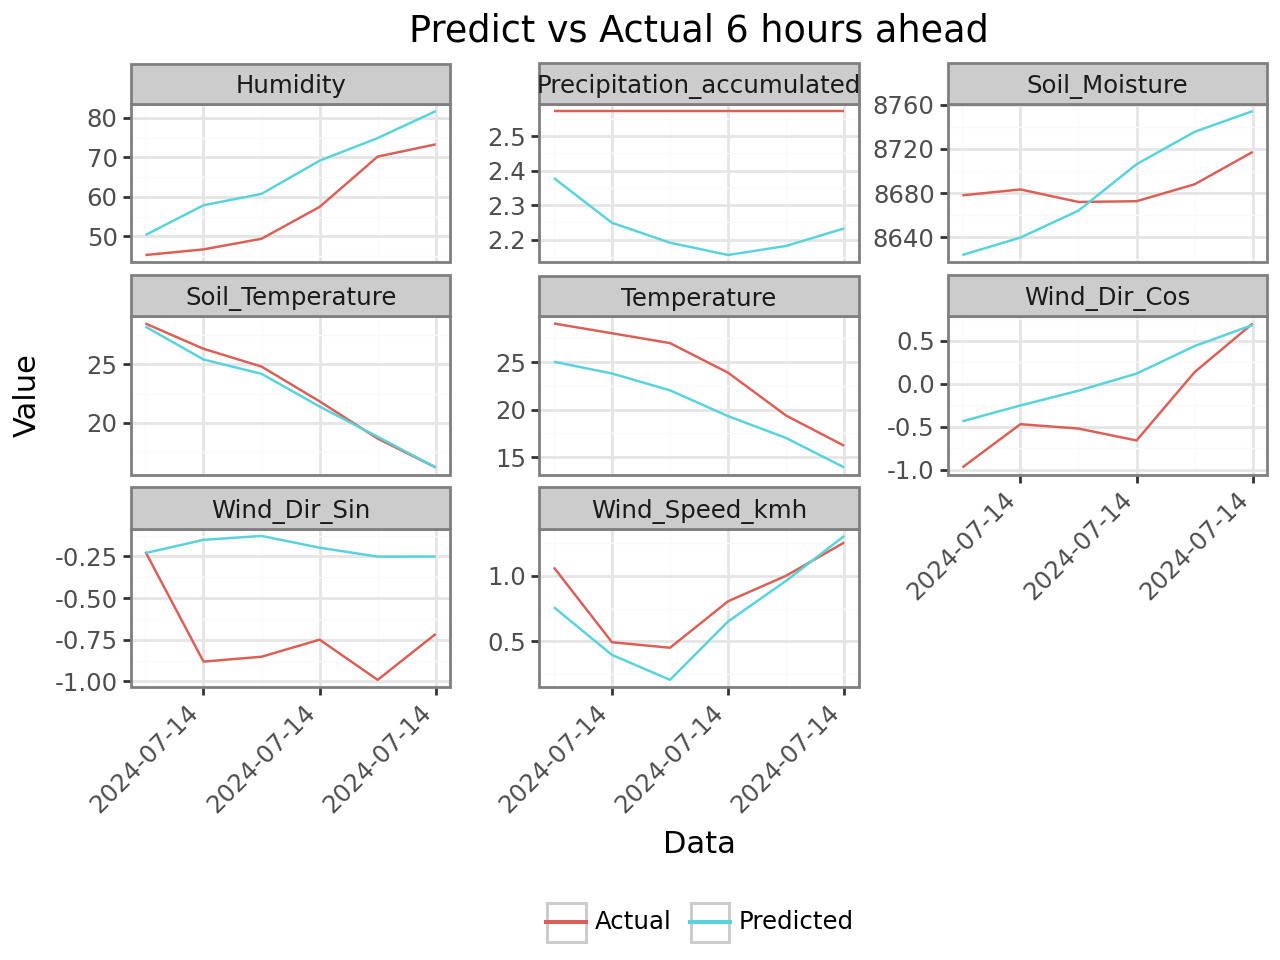

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/NHiTS/predict_6.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(15.11097684313898), 'RMSE': np.float64(3.8872839931163994), 'MAE': np.float64(3.7434957900189203), 'R2': np.float64(0.3207425110710195), 'SMAPE': np.float64(16.811304673166106)}, 'Precipitation_accumulated': {'MSE': np.float64(0.12182387682465627), 'RMSE': np.float64(0.34903277328161647), 'MAE': np.float64(0.3413555641242087), 'R2': np.float64(-6.177204423156216e+29), 'SMAPE': np.float64(14.26020371817606)}, 'Humidity': {'MSE': np.float64(84.69517142107946), 'RMSE': np.float64(9.202997958332897), 'MAE': np.float64(8.722960497559402), 'R2': np.float64(0.3131972659432195), 'SMAPE': np.float64(14.70984006599902)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.031407103107862815), 'RMSE': np.float64(0.17722049291169126), 'MAE': np.float64(0.14772476125041606), 'R2': np.float64(0.6363383261404221), 'SMAPE': np.float64(26.318026668532184)}, 'Soil_Moisture': {'MSE': np.float64(1607.0259707553134), 'RMSE': np.float64(40.08772843097141), 'MAE': np.float64(37.26993634

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

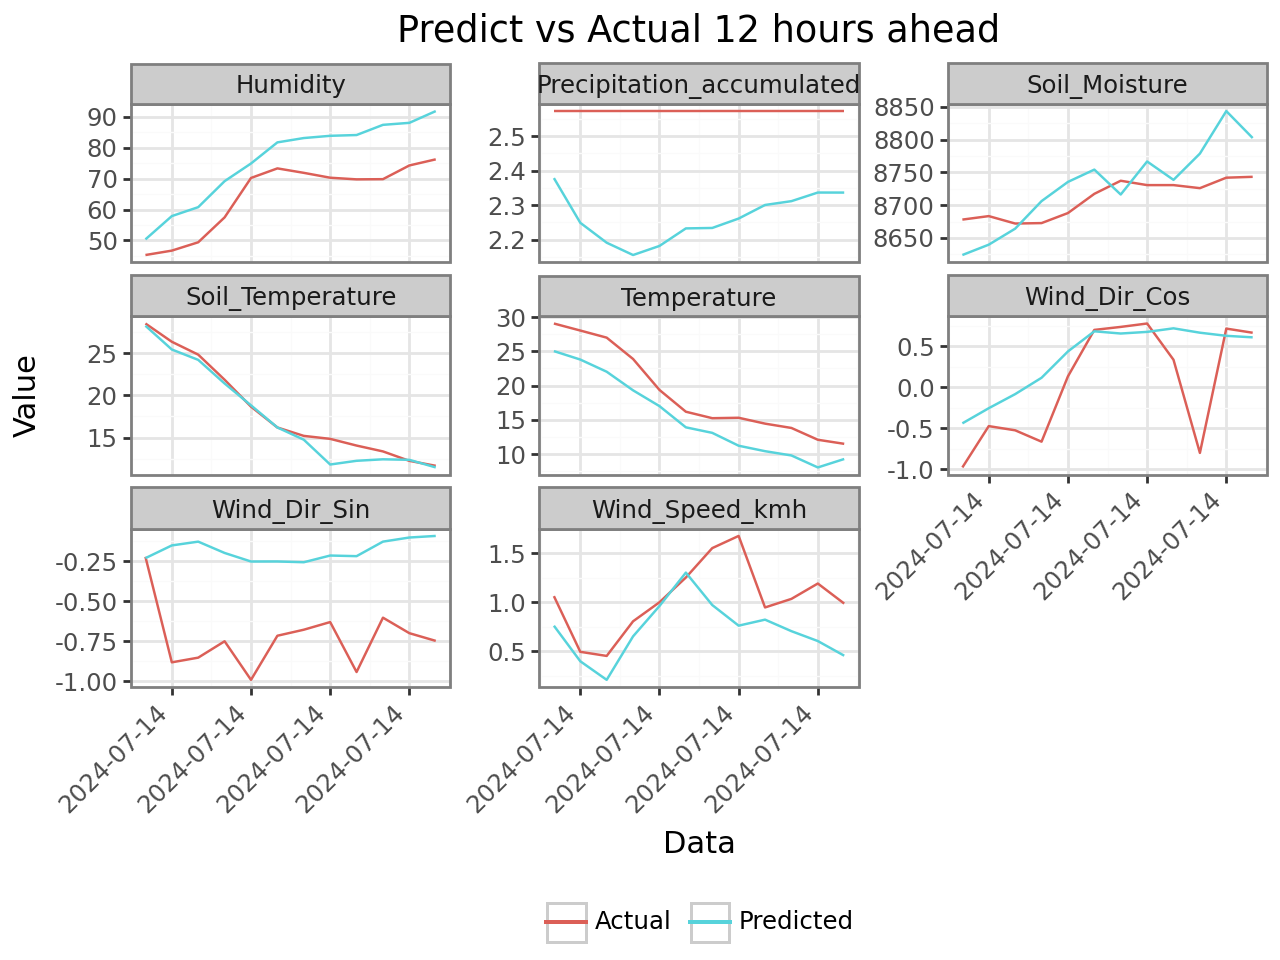

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/NHiTS/predict_12.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(13.788465606418704), 'RMSE': np.float64(3.713282322476801), 'MAE': np.float64(3.5816462035216134), 'R2': np.float64(0.6386978736240683), 'SMAPE': np.float64(22.877172856260547)}, 'Precipitation_accumulated': {'MSE': np.float64(0.09972636774813008), 'RMSE': np.float64(0.31579481906473716), 'MAE': np.float64(0.3086930124846706), 'R2': np.float64(-5.0567275973799295e+29), 'SMAPE': np.float64(12.80548293030287)}, 'Humidity': {'MSE': np.float64(146.97687714308432), 'RMSE': np.float64(12.123402044932945), 'MAE': np.float64(11.529455165557435), 'R2': np.float64(-0.218949813613871), 'SMAPE': np.float64(16.401891983886017)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.1769542412341875), 'RMSE': np.float64(0.42065929353122283), 'MAE': np.float64(0.33015265000597743), 'R2': np.float64(-0.4605839212856844), 'SMAPE': np.float64(39.21132589704795)}, 'Soil_Moisture': {'MSE': np.float64(2340.459532899206), 'RMSE': np.float64(48.37829609338475), 'MAE': np.float64(41.871733

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

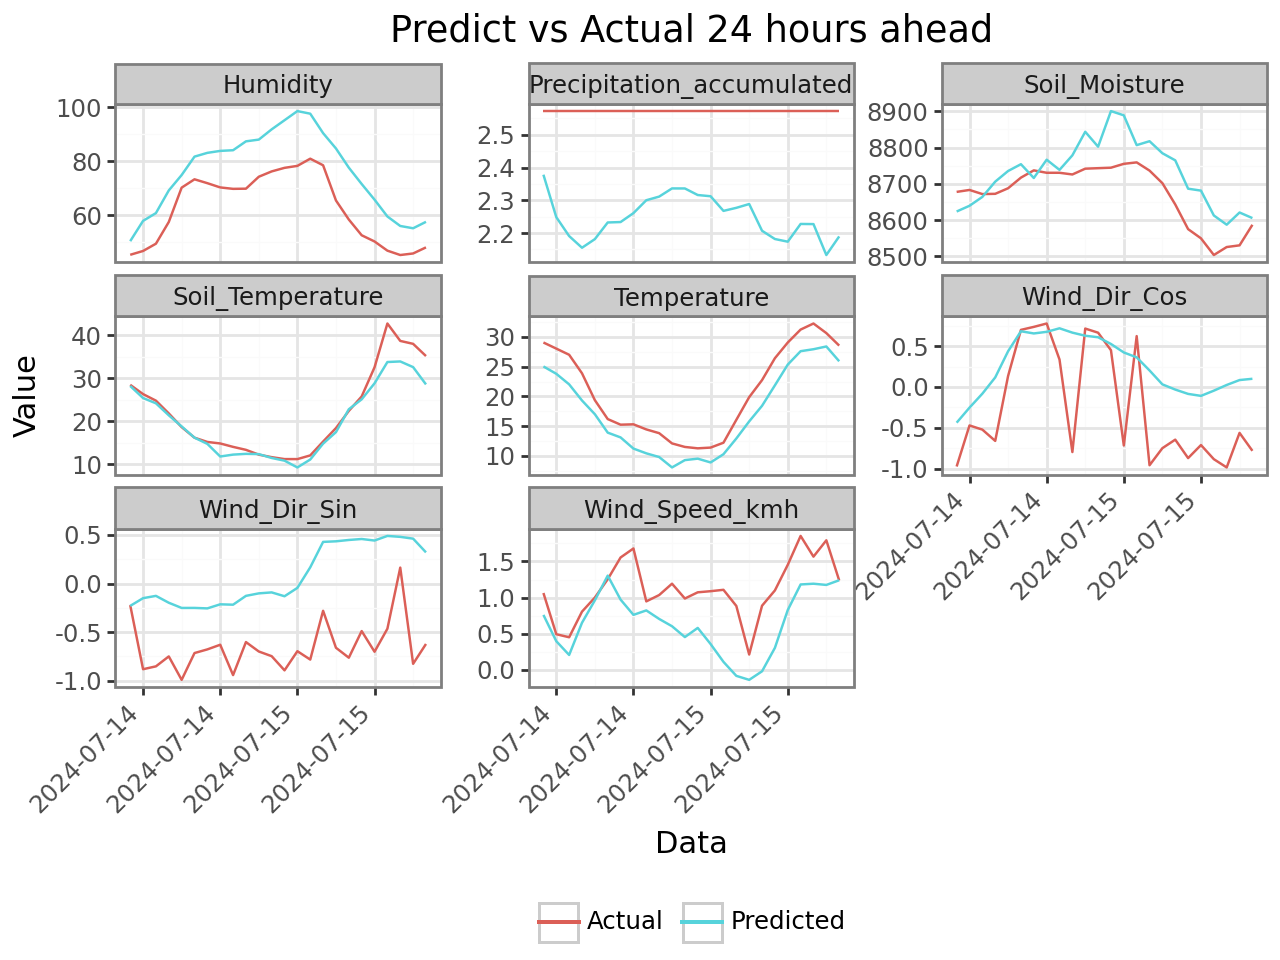

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/NHiTS/predict_24.png
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(12.5899577718478), 'RMSE': np.float64(3.5482330492581515), 'MAE': np.float64(3.4087789991905466), 'R2': np.float64(0.7642863970888469), 'SMAPE': np.float64(19.799765382941846)}, 'Precipitation_accumulated': {'MSE': np.float64(0.10889532120081236), 'RMSE': np.float64(0.32999291083417587), 'MAE': np.float64(0.32381540422817584), 'R2': np.float64(-inf), 'SMAPE': np.float64(13.46953650818371)}, 'Humidity': {'MSE': np.float64(196.01755858352726), 'RMSE': np.float64(14.000627078225007), 'MAE': np.float64(13.34078525299879), 'R2': np.float64(-0.21437449275336773), 'SMAPE': np.float64(19.411970660235536)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.32321729031550306), 'RMSE': np.float64(0.5685220227181205), 'MAE': np.float64(0.478533684810676), 'R2': np.float64(-1.0534659346926958), 'SMAPE': np.float64(69.78928169404287)}, 'Soil_Moisture': {'MSE': np.float64(6444.063090398875), 'RMSE': np.float64(80.27492192708053), 'MAE': np.float64(68.64316083617511), 'R2': np.

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

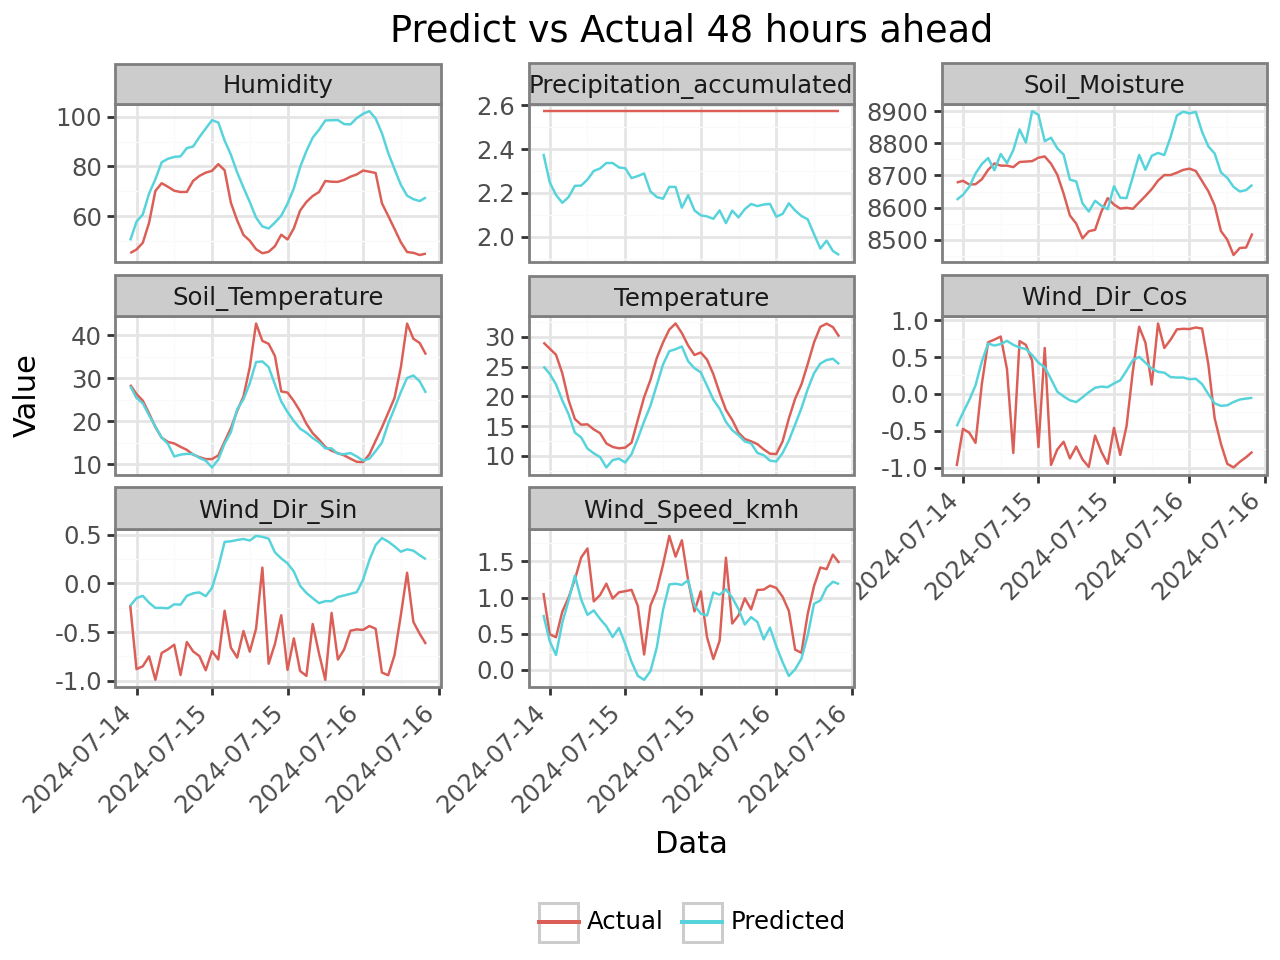

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/NHiTS/predict_48.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(12.479500644140307), 'RMSE': np.float64(3.532633669677668), 'MAE': np.float64(3.2116080873111623), 'R2': np.float64(0.7731024504186295), 'SMAPE': np.float64(17.322103420879998)}, 'Precipitation_accumulated': {'MSE': np.float64(0.17759880057198255), 'RMSE': np.float64(0.4214247270533405), 'MAE': np.float64(0.4076811500920085), 'R2': np.float64(-9.005329045795491e+29), 'SMAPE': np.float64(17.321741840881234)}, 'Humidity': {'MSE': np.float64(342.4591474507761), 'RMSE': np.float64(18.505651770493685), 'MAE': np.float64(17.52918205884006), 'R2': np.float64(-1.2447049321900279), 'SMAPE': np.float64(24.57219577940143)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.2849349557663478), 'RMSE': np.float64(0.5337929896189606), 'MAE': np.float64(0.45144329032047387), 'R2': np.float64(-0.670245020217666), 'SMAPE': np.float64(67.39116246890806)}, 'Soil_Moisture': {'MSE': np.float64(13231.802874758825), 'RMSE': np.float64(115.02957391366284), 'MAE': np.float64(99.361091117

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

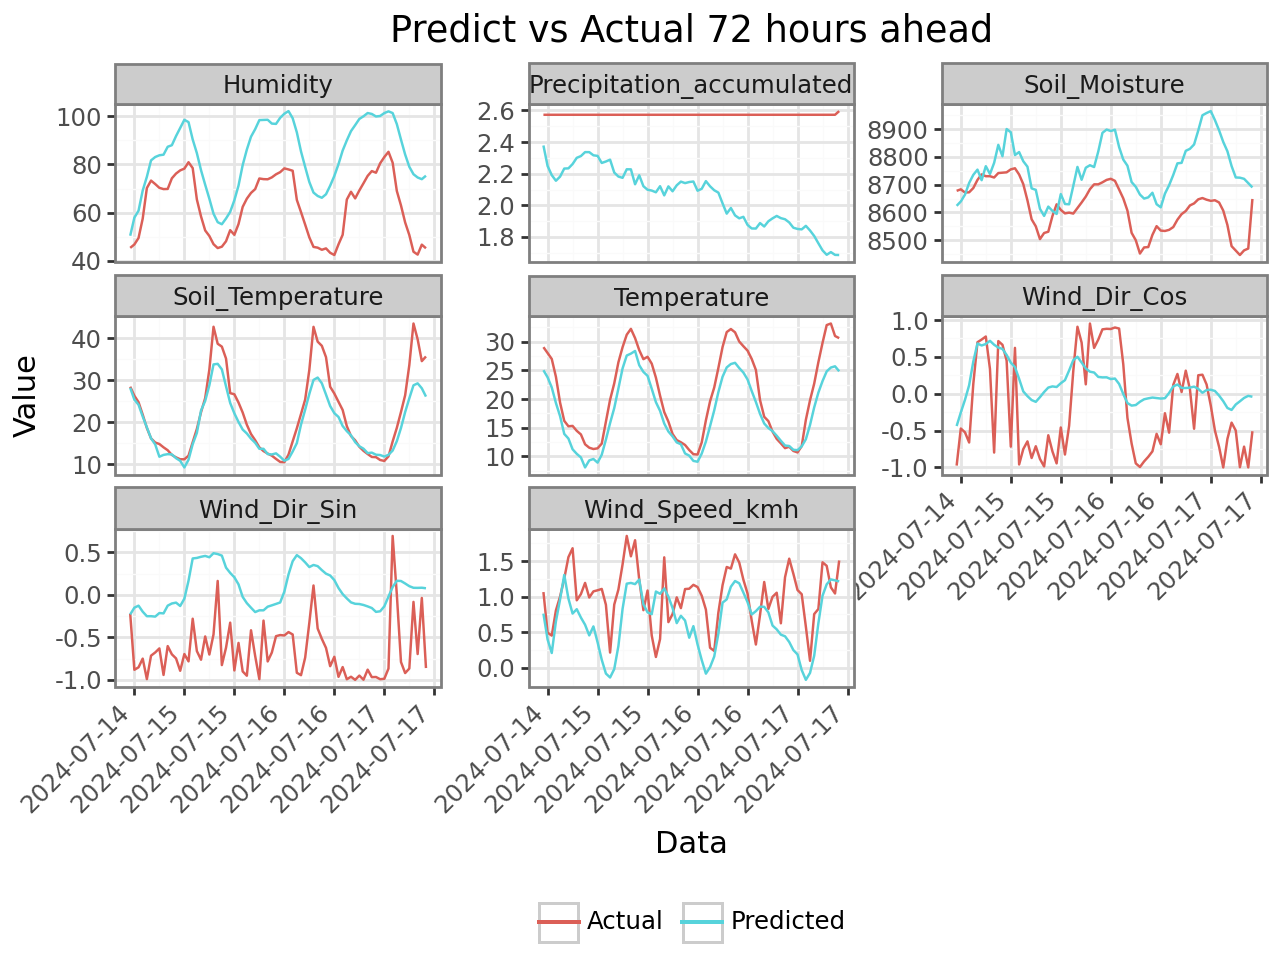

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/NHiTS/predict_72.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(14.224945792036781), 'RMSE': np.float64(3.7715972467956838), 'MAE': np.float64(3.2335923389854693), 'R2': np.float64(0.7521574739832453), 'SMAPE': np.float64(16.28341243883798)}, 'Precipitation_accumulated': {'MSE': np.float64(0.30234784388706193), 'RMSE': np.float64(0.5498616588625378), 'MAE': np.float64(0.5178597607639117), 'R2': np.float64(-40720.447629483984), 'SMAPE': np.float64(22.736787558515076)}, 'Humidity': {'MSE': np.float64(479.8867341936914), 'RMSE': np.float64(21.906317221150875), 'MAE': np.float64(20.707382125049865), 'R2': np.float64(-1.7877829037170914), 'SMAPE': np.float64(28.869966117425015)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.29294563136396196), 'RMSE': np.float64(0.5412445208627631), 'MAE': np.float64(0.44693972636013324), 'R2': np.float64(-0.8569839009146207), 'SMAPE': np.float64(68.26253545120703)}, 'Soil_Moisture': {'MSE': np.float64(26757.470700812704), 'RMSE': np.float64(163.5771093423915), 'MAE': np.float64(139.53559820

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

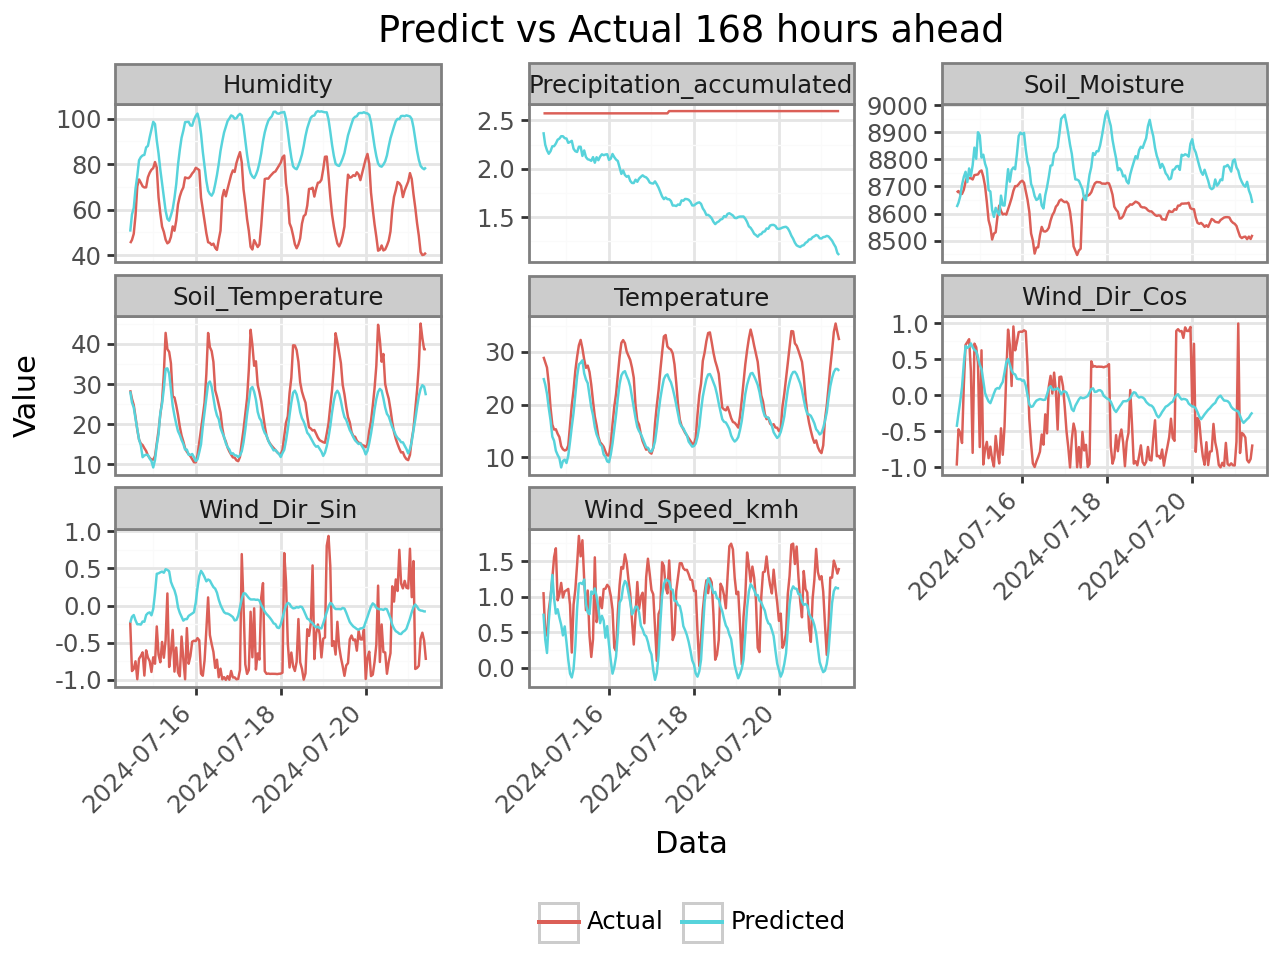

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/NHiTS/predict_168.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(17.438977368498556), 'RMSE': np.float64(4.176000163852793), 'MAE': np.float64(3.5202341585418226), 'R2': np.float64(0.68097400870554), 'SMAPE': np.float64(16.453899446790288)}, 'Precipitation_accumulated': {'MSE': np.float64(0.9264933347439372), 'RMSE': np.float64(0.9625452377649256), 'MAE': np.float64(0.891437096553573), 'R2': np.float64(-7002.908573544803), 'SMAPE': np.float64(43.25137576586218)}, 'Humidity': {'MSE': np.float64(733.6374525736113), 'RMSE': np.float64(27.08574260701765), 'MAE': np.float64(25.944503861540277), 'R2': np.float64(-3.117375865983237), 'SMAPE': np.float64(35.24559252209266)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.3826840447170011), 'RMSE': np.float64(0.6186146172836535), 'MAE': np.float64(0.513926203669571), 'R2': np.float64(-1.204071610166928), 'SMAPE': np.float64(78.38029365828744)}, 'Soil_Moisture': {'MSE': np.float64(31441.355560868746), 'RMSE': np.float64(177.31710453554317), 'MAE': np.float64(161.34458080288317), 'R2

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

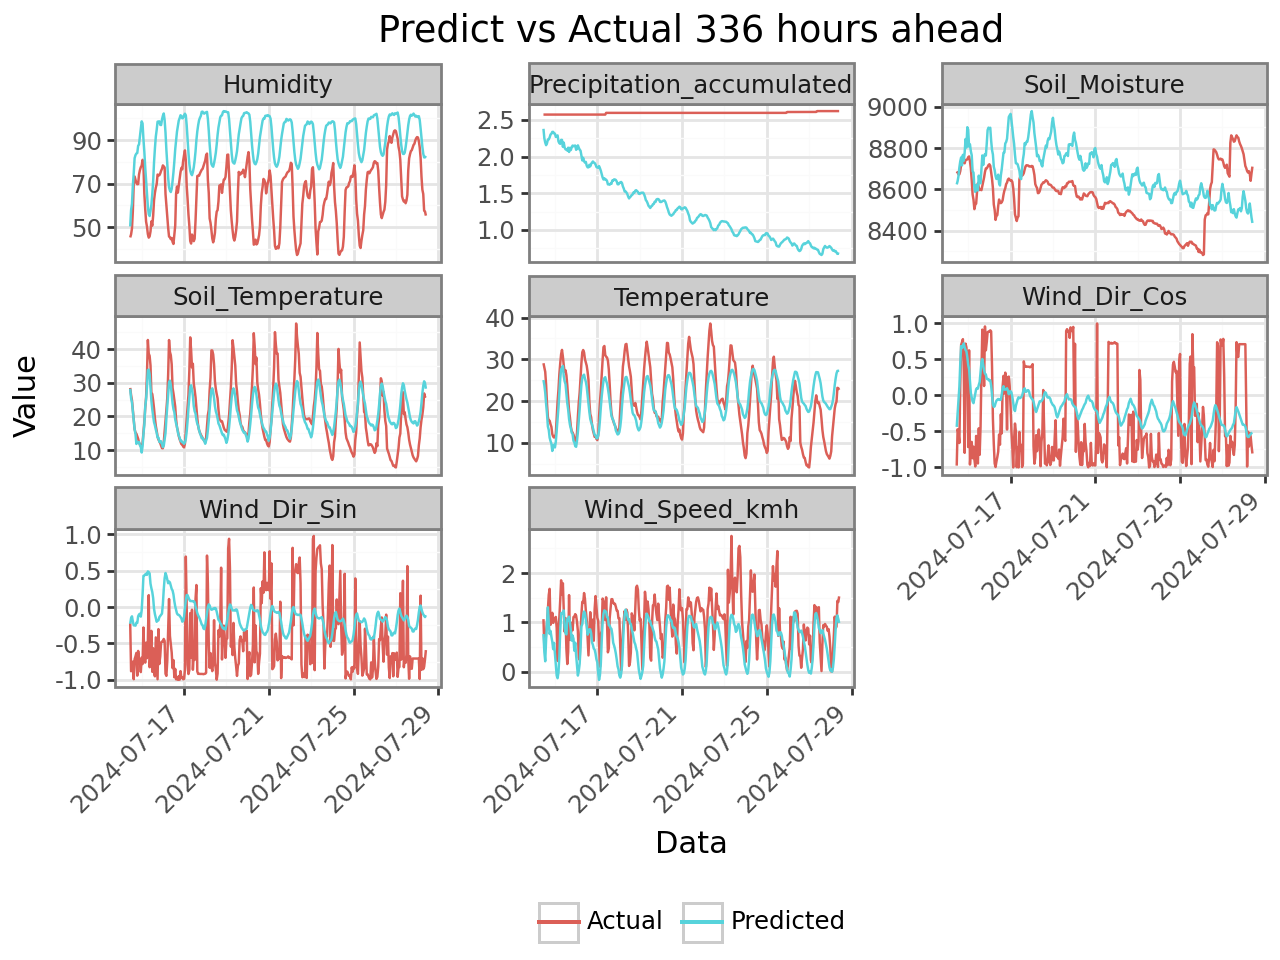

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/NHiTS/predict_336.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(32.25416830136863), 'RMSE': np.float64(5.6792753324142184), 'MAE': np.float64(4.721861252477182), 'R2': np.float64(0.4968676851006155), 'SMAPE': np.float64(26.25491868702518)}, 'Precipitation_accumulated': {'MSE': np.float64(1.9047370486485053), 'RMSE': np.float64(1.3801221136727377), 'MAE': np.float64(1.2910467838656334), 'R2': np.float64(-11038.052961868398), 'SMAPE': np.float64(70.00209200379993)}, 'Humidity': {'MSE': np.float64(734.86097351495), 'RMSE': np.float64(27.108319267615062), 'MAE': np.float64(25.81958053110109), 'R2': np.float64(-2.4974867571617727), 'SMAPE': np.float64(34.845734632125556)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.39006541284030893), 'RMSE': np.float64(0.6245521698307588), 'MAE': np.float64(0.5102632760672869), 'R2': np.float64(-0.5424257916618744), 'SMAPE': np.float64(78.1867475559996)}, 'Soil_Moisture': {'MSE': np.float64(38291.40084353079), 'RMSE': np.float64(195.68188685601638), 'MAE': np.float64(180.82589185596515), 

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

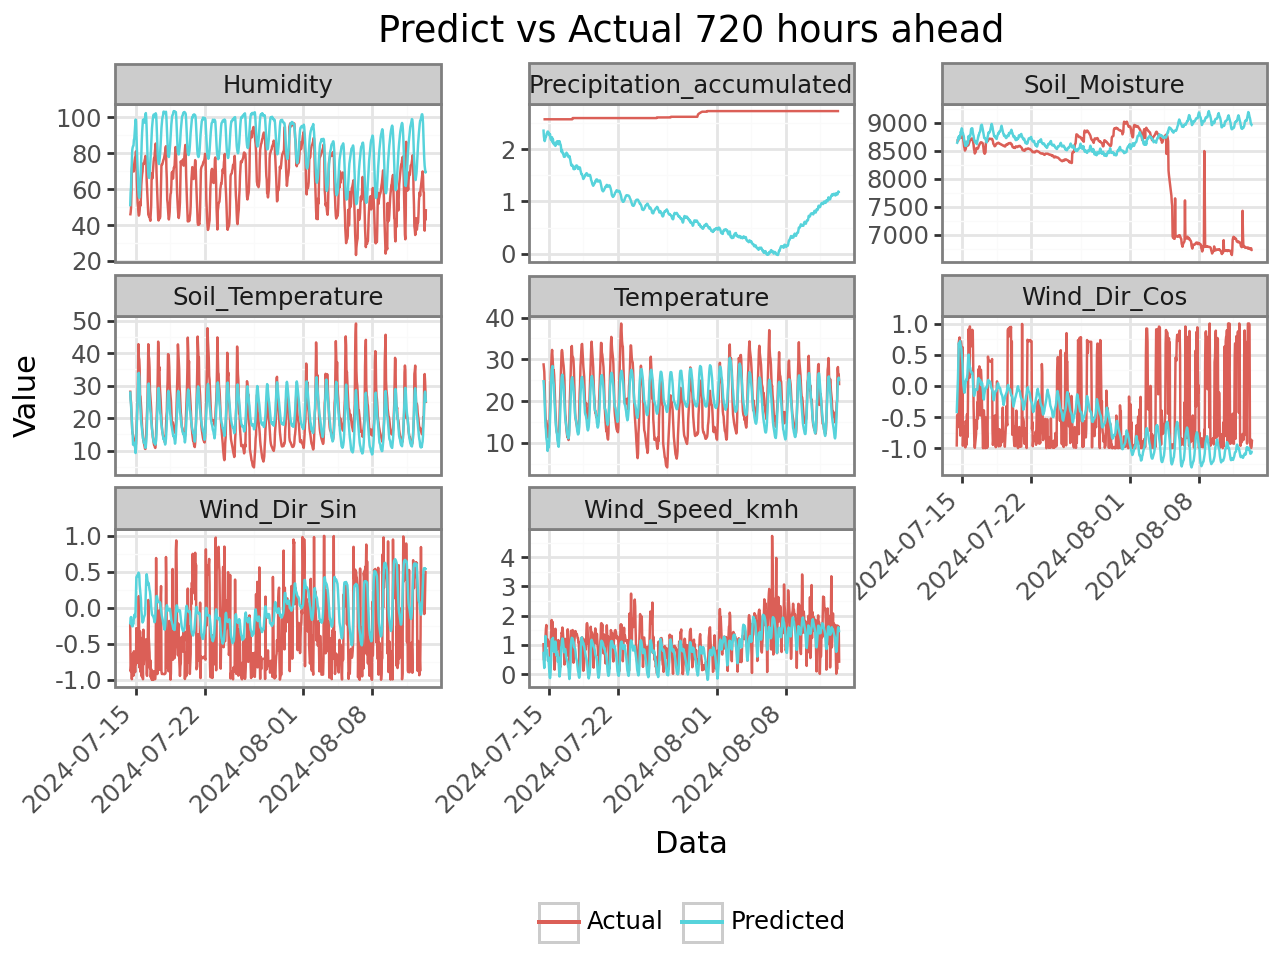

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/NHiTS/predict_720.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(26.207888740420792), 'RMSE': np.float64(5.119364095316994), 'MAE': np.float64(4.253069567746238), 'R2': np.float64(0.4803941198855338), 'SMAPE': np.float64(23.118718372727482)}, 'Precipitation_accumulated': {'MSE': np.float64(3.6389620066108908), 'RMSE': np.float64(1.907606355255426), 'MAE': np.float64(1.801484891889309), 'R2': np.float64(-822.233951299328), 'SMAPE': np.float64(109.57404143684643)}, 'Humidity': {'MSE': np.float64(590.3497984072696), 'RMSE': np.float64(24.297115022308095), 'MAE': np.float64(22.19944536395982), 'R2': np.float64(-1.2038912747467982), 'SMAPE': np.float64(32.053955365091994)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.3796029901052421), 'RMSE': np.float64(0.6161192985982845), 'MAE': np.float64(0.4941524095599947), 'R2': np.float64(0.14818943861291312), 'SMAPE': np.float64(62.58751122729118)}, 'Soil_Moisture': {'MSE': np.float64(1344460.725449116), 'RMSE': np.float64(1159.5088293967908), 'MAE': np.float64(740.3160947024012), '

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

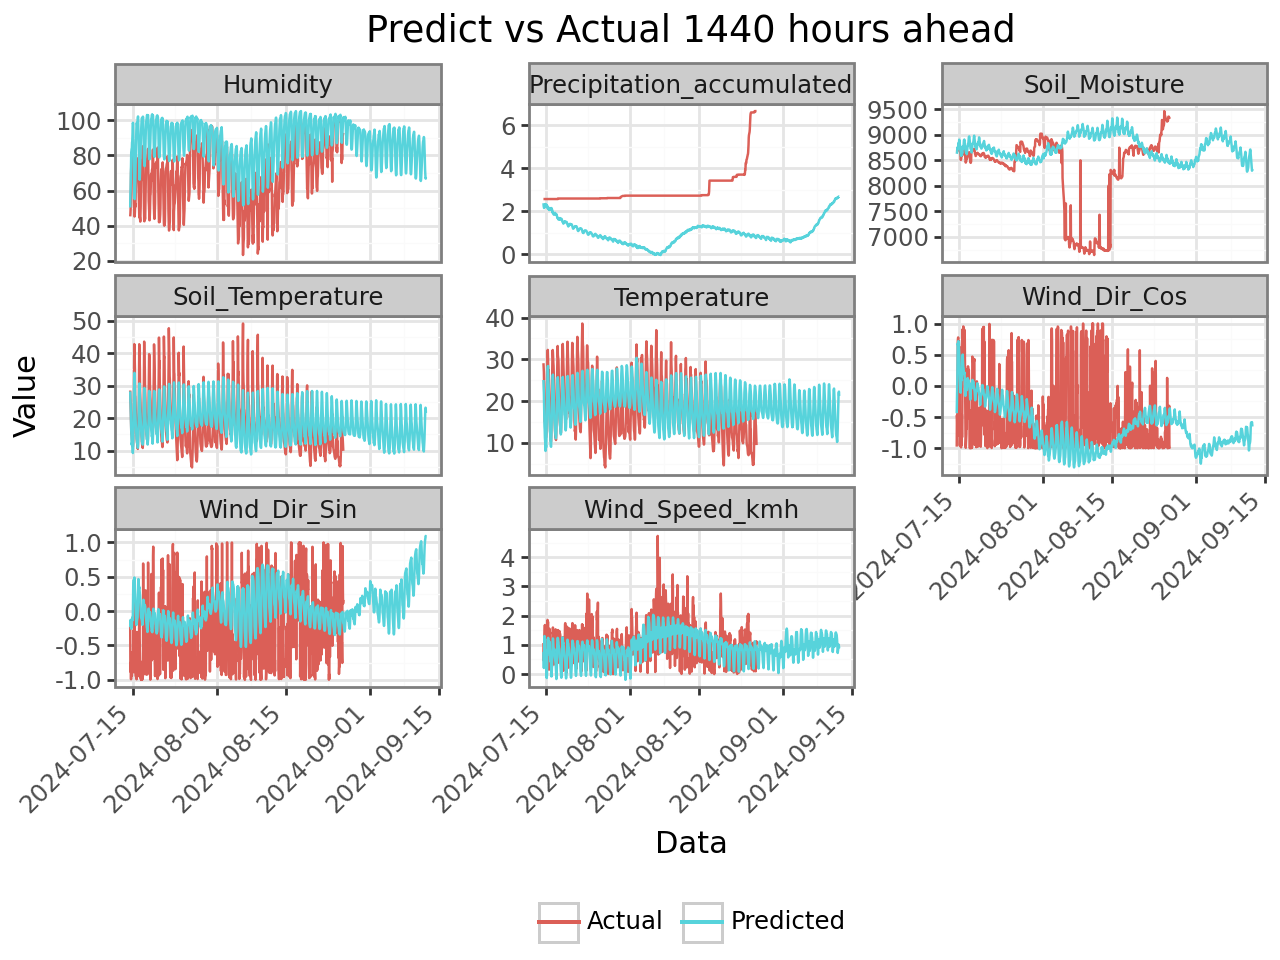

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/NHiTS/predict_1440.png


{'Temperature': {'MSE': np.float64(27.47239176161762), 'RMSE': np.float64(5.241411237597907), 'MAE': np.float64(4.363529179737179), 'R2': np.float64(0.45382839976488465), 'SMAPE': np.float64(25.730959147101448)}, 'Precipitation_accumulated': {'MSE': np.float64(5.056127933752985), 'RMSE': np.float64(2.248583539420536), 'MAE': np.float64(2.042970926884945), 'R2': np.float64(-7.187726034684404), 'SMAPE': np.float64(107.43835197615454)}, 'Humidity': {'MSE': np.float64(479.4949477160043), 'RMSE': np.float64(21.897373077974542), 'MAE': np.float64(19.33120043643376), 'R2': np.float64(-0.5431833501449017), 'SMAPE': np.float64(26.980403385264676)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.35711148972521034), 'RMSE': np.float64(0.5975880602264493), 'MAE': np.float64(0.4764757012121893), 'R2': np.float64(0.14215727024458924), 'SMAPE': np.float64(61.241909914539676)}, 'Soil_Moisture': {'MSE': np.float64(1149448.7639444352), 'RMSE': np.float64(1072.1234835336998), 'MAE': np.float64(694.9169192996293)

In [8]:
m = "NHiTS"
for i in [3,6,12,24,48,72,168,336,720,1440]:
    pred = model.predict(
        series=best_train_scaled,
        n=i,
        verbose=True
    )

    metrics={}

    pred_t = best_scaler.inverse_transform(pred)
    pred_df = pred_t.to_dataframe()
    pred_df = pred_df.reset_index()
    pred_df = pred_df.rename(columns={"time": "Timestamp"})
    plot_columns = ['Timestamp'] + target_columns
    pred_melted = pred_df[plot_columns].melt(
        id_vars='Timestamp',
        var_name='target_column',
        value_name='value'
    )
    pred_melted['type'] = 'Predicted'

    # Get validation data for comparison
    val_t = best_scaler.inverse_transform(best_val_scaled[:i])
    val_df = val_t.to_dataframe()
    val_df = val_df.reset_index()
    val_df = val_df.rename(columns={"time": "Timestamp"})
    val_melted = val_df[plot_columns].melt(
        id_vars='Timestamp',
        var_name='target_column',
        value_name='value'
    )
    val_melted['type'] = 'Actual'

    # Combine predicted and validation data
    combined_df = pd.concat([pred_melted, val_melted])

    plot = (
        ggplot(combined_df, aes(x='Timestamp', y='value', color='type'))
        + geom_line()
        + facet_wrap('~ target_column', scales='free_y')
        + labs(
            title=f'Predict vs Actual {i} hours ahead',
            x='Data',
            y='Value',
            color='Data type'
        )
        + theme_bw()
        + theme(
            axis_text_x=element_text(rotation=45, hjust=1),
            legend_position='bottom',
            legend_title=element_blank(),

        )
    )
    plot.show()
    plot.save(f'results/{m}/predict_{i}.png', width=12, height=10, dpi=300)


    s = best_scaler.inverse_transform(best_val_scaled[:i])
    for target in target_columns:
        metrics[target] = {
            'MSE': mse(s[target], pred_t[target]),
            'RMSE': rmse(s[target], pred_t[target]),
            'MAE': mae(s[target], pred_t[target]),
            'R2': r2_score(s[target], pred_t[target]),
            'SMAPE': smape(s[target], pred_t[target]),
        }
    print(metrics)
    with open(f'results/{m}/metrics{i}.json', 'w') as f:
        json.dump(metrics, f, indent=4)


In [9]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)